In [15]:
import os
import numpy as np 
import pandas as pd
from tqdm.notebook import tqdm
import string
import os
from pickle import dump ,load
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding, Input, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint ,LearningRateScheduler

In [2]:
from utils import *

In [3]:
path = os.getcwd()

In [4]:
a = retieve_image_name(path + "\\Text", "Flickr_8k.trainImages.txt")

In [5]:
#LOADING AND PICKLE SAVIN THE FEATURES EXTRACTED FROM inception v3
#features_images = load_and_get_afe_1(path + "\\Flicker8k_Dataset")
#dump(features_images, open("features.pkl", "wb"))

In [4]:
token_desc = load_description(path + "\\Text", "Flickr8k.token.txt")
print("LOADED : {0}".format(len(token_desc)))
clean_tokens = clean_description(token_desc)
print("CLEANDED !!!! : {0}".format(len(clean_tokens)))

LOADED : 8092
Processing Started



Processing Done !!!!!!
CLEANDED !!!! : 8092


In [5]:
vocublary = 8763

In [6]:
#NOT TO BE USED AGAIN
#save_description(clean_tokens, "descriptions.txt")

In [7]:
train_images_names = retieve_image_name(path + "\\Text", "Flickr_8k.trainImages.txt")
print("TRAIN_dataset : {0}".format(len(train_images_names)))
train_description = create_mapping_train_captions(train_images_names, clean_tokens)
print("LOADED Train_descriptions : {0}".format(len(train_description)))
train_features = load_photo_features("features.pkl", train_images_names)
print("LOADED Train_features : {0} --- {1}".format(len(train_features), type(train_features)))

TRAIN_dataset : 6000
LOADED Train_descriptions : 6000
LOADED Train_features : 6000 --- <class 'dict'>


In [8]:
tokenizer = create_tokenizer(train_description)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab size : {0}".format(vocab_size))

Vocab size : 7579


In [9]:
max_len = max_length(train_description)
print("Max length of data : {0}".format(max_len))

Max length of data : 34


In [10]:
X1_train, X2_train , y_train = create_sequences(tokenizer=tokenizer, max_length=max_len, descriptions=train_description, photos=train_features, vocab_size=vocab_size)

In [11]:
import gc
del train_description, train_features
gc.collect()

7341

In [16]:
# callbacks
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
mse_save = ModelCheckpoint("v1.hdf5", monitor = 'accuracy', save_best_only=True)

In [22]:
def model_nn(input_shape_image, vocab_size, max_length, embed_dims):
    #FOR THE IMAGE INPUT 
    inputs1 = Input(input_shape_image)
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    ##RNN PART
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embed_dims, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    ##DECODER
    decoder1 = tf.keras.layers.Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    #MODEL
    model = Model([inputs1, inputs2], outputs)
    print(model.summary())
    return model

In [23]:
capt_model = model_nn(input_shape_image=(2048, ), vocab_size=vocab_size, max_length = max_len, embed_dims=256)
capt_model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [24]:
capt_model.fit([X1_train, X2_train], y_train, epochs=3, callbacks=[annealer, mse_save], batch_size = 128)

Train on 306404 samples
Epoch 1/3
306404/306404 [==============================] - 651s 2ms/sample - loss: 4.3952 - accuracy: 0.2411
Epoch 2/3
306404/306404 [==============================] - 628s 2ms/sample - loss: 3.5788 - accuracy: 0.3034
Epoch 3/3
306404/306404 [==============================] - 648s 2ms/sample - loss: 3.2764 - accuracy: 0.3263


In [20]:
#capt_model.save("wow1epoch.hdf5")

2945

In [25]:
model_nn = load_model("v1.hdf5")
model_nn.trainable = False
model_nn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

In [26]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [27]:
def generate_cap(model, tokenizer, photo, max_length):
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose = 0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [37]:
photo = tf.keras.preprocessing.image.load_img("puppy_test.jpg", target_size = (299, 299))
image1 = tf.keras.preprocessing.image.img_to_array(photo)
image = np.expand_dims(image1, axis = 0)
image = tf.keras.applications.inception_v3.preprocess_input(image)
print(image.shape)

(1, 299, 299, 3)


In [29]:
mod = tf.keras.applications.InceptionV3(weights = "imagenet")
mod = tf.keras.models.Model(mod.input, mod.layers[-2].output)
mod.trainable = False

In [38]:
out = mod.predict(image)
print(out.shape)

(1, 2048)


In [35]:
import matplotlib.pyplot as plt
import cv2

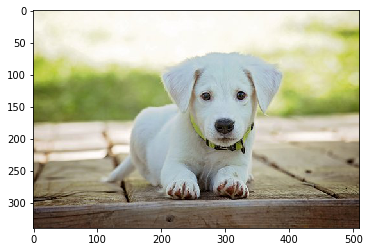

 black dog is running through the grass  

In [39]:
img = cv2.imread("puppy_test.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
print(generate_cap(model_nn, tokenizer, out, max_len)[8:-6], end = " ")